## 1. Import Data & Library

In [0]:
!wget -nc 140.114.76.113:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

--2019-12-08 07:01:37--  http://140.114.76.113:8000/ccpd6000.zip
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332013713 (317M) [application/zip]
Saving to: ‘ccpd6000.zip’

ccpd6000.zip        100%[===================>] 316.63M  6.83MB/s    in 73s     

2019-12-08 07:02:50 (4.36 MB/s) - ‘ccpd6000.zip’ saved [332013713/332013713]

total 317M
drwxr-xr-x 1 root root 4.0K Dec  8 07:02 .
drwxr-xr-x 1 root root 4.0K Dec  8 07:00 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  5 16:38 .config
drwxr-xr-x 1 root root 4.0K Nov 27 22:38 sample_data


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

#from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
#from keras.applications.InceptionResNetV2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#keras.applications.inception_resnet_v2.InceptionResNetV2
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

# (192, 320)
WIDTH = 192
HEIGHT = 320
CHANNEL = 3

In [0]:
label = pd.read_csv('./ccpd6000/train.csv')
label.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
0,0000.jpg,373.0,565.0,132.0,519.0,126.0,448.0,367.0,494.0
1,0001.jpg,597.0,528.0,282.0,523.0,283.0,438.0,599.0,443.0
2,0002.jpg,438.0,539.0,193.0,536.0,187.0,464.0,432.0,467.0
3,0003.jpg,440.0,538.0,167.0,532.0,167.0,463.0,440.0,469.0
4,0004.jpg,379.0,613.0,163.0,585.0,160.0,522.0,375.0,549.0


In [0]:
img = cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[0])
print(img.shape)

(1160, 720, 3)


## 2. Data Exploration

In [0]:
def show_img(index):
    img = cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_list = []; y_list = []
    for i in range(4):
      x_list.append(label.iloc[index,i*2+1])
      y_list.append(label.iloc[index,i*2+2])
    plt.plot(x_list,y_list,"o", label="original point")
    plt.imshow(img)

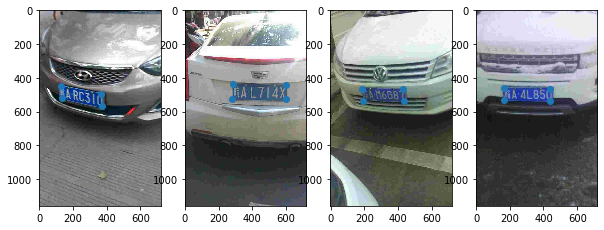

In [0]:
plt.figure(figsize=(10,8)); plt.subplot(1,4,1); show_img(0); plt.subplot(1,4,2); show_img(1); plt.subplot(1,4,3); show_img(2); plt.subplot(1,4,4); show_img(3)

## 3. Data Preprocessing
Due to the image will been reshape to (320,192) from (1160, 720) for performance & memory reduction, we change the coordinator to ratio for sigmoid function at output layer in CNN.

In [0]:
label.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
0,0000.jpg,373.0,565.0,132.0,519.0,126.0,448.0,367.0,494.0
1,0001.jpg,597.0,528.0,282.0,523.0,283.0,438.0,599.0,443.0
2,0002.jpg,438.0,539.0,193.0,536.0,187.0,464.0,432.0,467.0
3,0003.jpg,440.0,538.0,167.0,532.0,167.0,463.0,440.0,469.0
4,0004.jpg,379.0,613.0,163.0,585.0,160.0,522.0,375.0,549.0


In [0]:
List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,1]/img.shape[1])
label['BR_x1'] = List

List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,2]/img.shape[0])
label['BR_y1'] = List

List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,3]/img.shape[1])
label['BL_x1'] = List

List = [] 
for i in range(label.shape[0]):
     List.append(label.iloc[i,4]/img.shape[0])
label['BL_y1'] = List

List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,5]/img.shape[1])
label['TL_x1'] = List

List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,6]/img.shape[0])
label['TL_y1'] = List

List = [] 
for i in range(label.shape[0]):
    List.append(label.iloc[i,7]/img.shape[1])
label['TR_x1'] = List

List = [] 
for i in range(label.shape[0]):
  List.append(label.iloc[i,8]/img.shape[0])
label['TR_y1'] = List

label.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y,BR_x1,BR_y1,BL_x1,BL_y1,TL_x1,TL_y1,TR_x1,TR_y1
0,0000.jpg,373.0,565.0,132.0,519.0,126.0,448.0,367.0,494.0,0.518056,0.487069,0.183333,0.447414,0.175000,0.386207,0.509722,0.425862
1,0001.jpg,597.0,528.0,282.0,523.0,283.0,438.0,599.0,443.0,0.829167,0.455172,0.391667,0.450862,0.393056,0.377586,0.831944,0.381897
2,0002.jpg,438.0,539.0,193.0,536.0,187.0,464.0,432.0,467.0,0.608333,0.464655,0.268056,0.462069,0.259722,0.400000,0.600000,0.402586
3,0003.jpg,440.0,538.0,167.0,532.0,167.0,463.0,440.0,469.0,0.611111,0.463793,0.231944,0.458621,0.231944,0.399138,0.611111,0.404310
4,0004.jpg,379.0,613.0,163.0,585.0,160.0,522.0,375.0,549.0,0.526389,0.528448,0.226389,0.504310,0.222222,0.450000,0.520833,0.473276


In [0]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
name     3000 non-null object
BR_x     3000 non-null float64
BR_y     3000 non-null float64
BL_x     3000 non-null float64
BL_y     3000 non-null float64
TL_x     3000 non-null float64
TL_y     3000 non-null float64
TR_x     3000 non-null float64
TR_y     3000 non-null float64
BR_x1    3000 non-null float64
BR_y1    3000 non-null float64
BL_x1    3000 non-null float64
BL_y1    3000 non-null float64
TL_x1    3000 non-null float64
TL_y1    3000 non-null float64
TR_x1    3000 non-null float64
TR_y1    3000 non-null float64
dtypes: float64(16), object(1)
memory usage: 398.6+ KB


In [0]:
def show_img2(index):
    img = cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, dsize=(WIDTH, HEIGHT))
    x_list = []; y_list = []
    for i in range(4):
        x_list.append(np.int(label.iloc[index,i*2+9]*WIDTH))
        y_list.append(np.int(label.iloc[index,i*2+10]*HEIGHT))
    plt.plot(x_list,y_list,"o", label="original point")
    plt.imshow(img1)

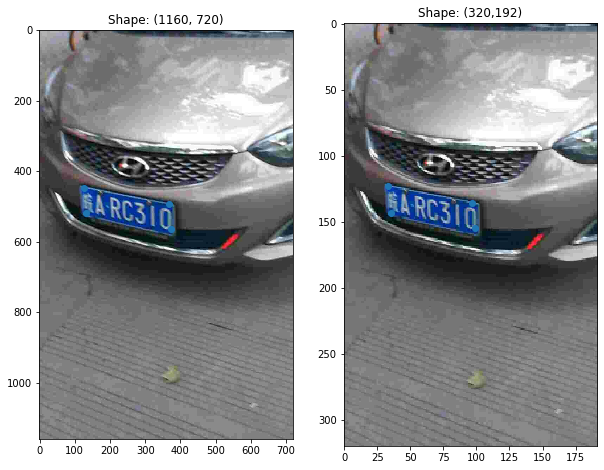

In [0]:
plt.figure(figsize=(10,8)); plt.subplot(1,2,1); plt.title('Shape: (1160, 720)'); show_img(0); plt.subplot(1,2,2); plt.title('Shape: (320,192)'); show_img2(0)

## 4. Model Training & Validation

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    label,
    directory="./ccpd6000/train_images/",
    x_col="name",
    y_col=['BR_x1','BR_y1','BL_x1','BL_y1','TL_x1','TL_y1','TR_x1','TR_y1'],
    target_size=(HEIGHT, WIDTH),
    batch_size=32,
    class_mode='raw',
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    label,
    directory="./ccpd6000/train_images/",
    x_col="name",
    y_col=['BR_x1','BR_y1','BL_x1','BL_y1','TL_x1','TL_y1','TR_x1','TR_y1'],
    target_size=(HEIGHT, WIDTH),
    batch_size=32,
    class_mode='raw',
    subset="validation")

Found 2700 validated image filenames.
Found 300 validated image filenames.


In [0]:
model = Sequential()
model.add(InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
##model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.1))
model.add(Dense(8, activation="sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 4, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
Total params: 60,641,256
Trainable params: 60,580,712
Non-trainable params: 60,544
_____________________________________

In [0]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 85
Validation step size: 10


Evaluation

The metric is the root mean-square error between the predicted locations and the ground-truth locations of the 3000 testing images:

$$
\newcommand{\norm}[1]{\lVert #1 \rVert}
RMSE = \sqrt{
\frac{1}{4N} 
\sum_{i=1}^{N} \sum_{j=1}^{4} 
\norm{\mathbf{p}_i^j - \mathbf{\hat p}_i^j}^2
}
$$


In [0]:
from keras import losses
# RMSE
import keras.backend as K
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Learning Rate
adam = Adam(lr=0.00005)
model.compile(optimizer=adam, loss=RMSE)

(1) Training & Validation

In [0]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=40)

Epoch 1/40
85/85 [==============================] - 162s 2s/step - loss: 0.0702 - val_loss: 0.0394
Epoch 2/40
85/85 [==============================] - 75s 877ms/step - loss: 0.0294 - val_loss: 0.0264
Epoch 3/40
85/85 [==============================] - 74s 873ms/step - loss: 0.0201 - val_loss: 0.0222
Epoch 4/40
85/85 [==============================] - 74s 874ms/step - loss: 0.0170 - val_loss: 0.0200
Epoch 5/40
85/85 [==============================] - 74s 874ms/step - loss: 0.0145 - val_loss: 0.0188
Epoch 6/40
85/85 [==============================] - 74s 874ms/step - loss: 0.0134 - val_loss: 0.0176
Epoch 7/40
85/85 [==============================] - 74s 875ms/step - loss: 0.0124 - val_loss: 0.0168
Epoch 8/40
85/85 [==============================] - 74s 875ms/step - loss: 0.0107 - val_loss: 0.0162
Epoch 9/40
85/85 [==============================] - 74s 873ms/step - loss: 0.0106 - val_loss: 0.0157
Epoch 10/40
85/85 [==============================] - 74s 876ms/step - loss: 0.0098 - val_loss

In [0]:
def show_img5(index):
    img_test = cv2.resize(cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[index]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img_test.reshape(1, HEIGHT,WIDTH, 3))
    img = cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x_list = []; y_list = []
    for i in range(4):
        x_list.append(np.int(label.iloc[index,i*2+1]))
        y_list.append(np.int(label.iloc[index,i*2+2]))
    plt.plot(x_list,y_list,"o", label="blue point",markersize=16)

    x_list1 = []; y_list1 = []
    for i in range(4):
        x_list1.append(np.int(y_hat[0][i*2]*img.shape[1]))
        y_list1.append(np.int(y_hat[0][i*2+1]*img.shape[0],))
    plt.plot(x_list1,y_list1,"X", label="original point",markersize=16)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.legend(['Training', 'Validation'], loc='upper right',fontsize=13)
    plt.imshow(img)    

(2) Visualization of 25 training samples, 25 validation samples every epoch during training.

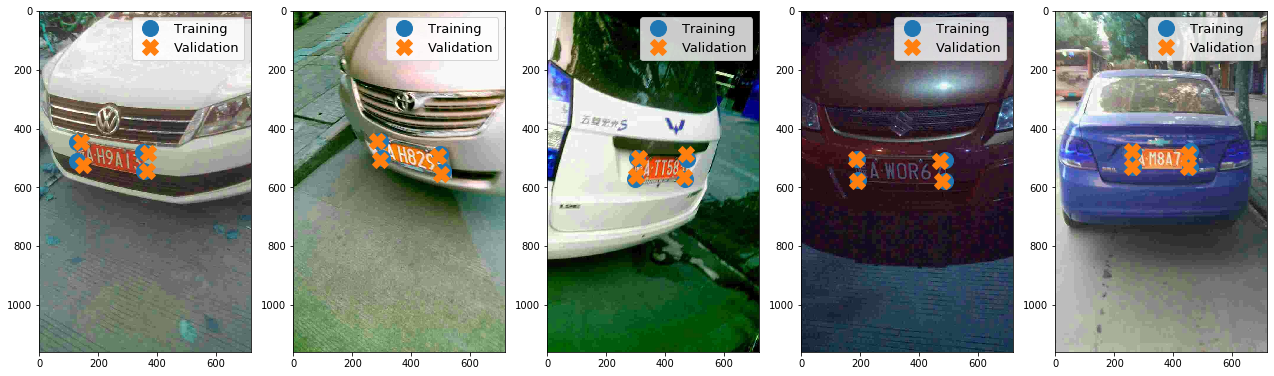

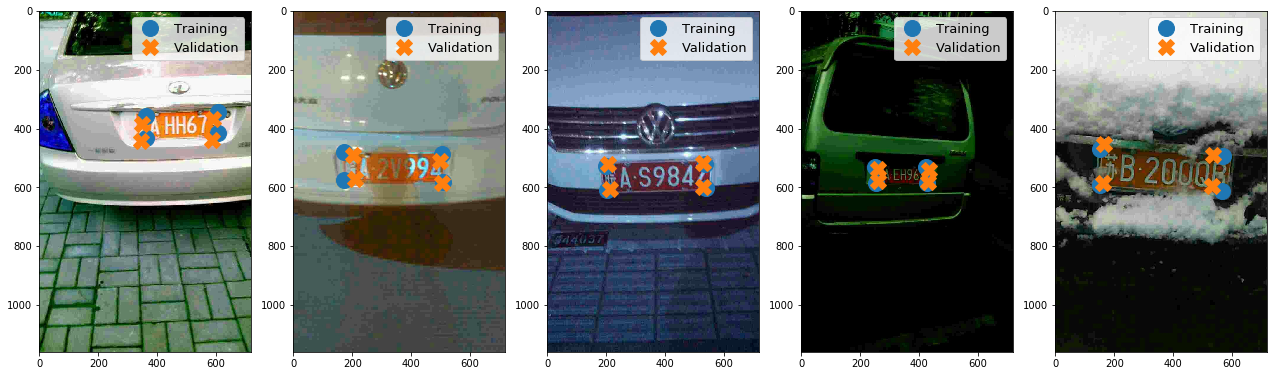

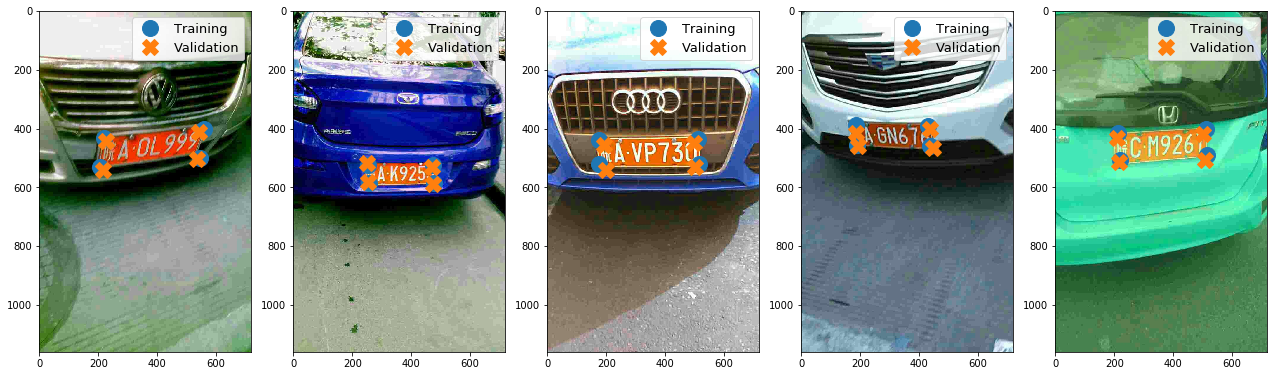

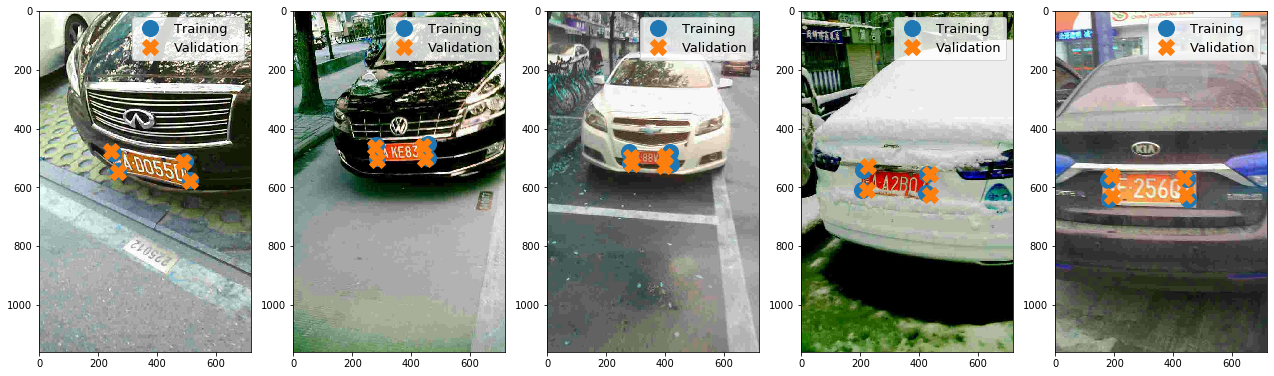

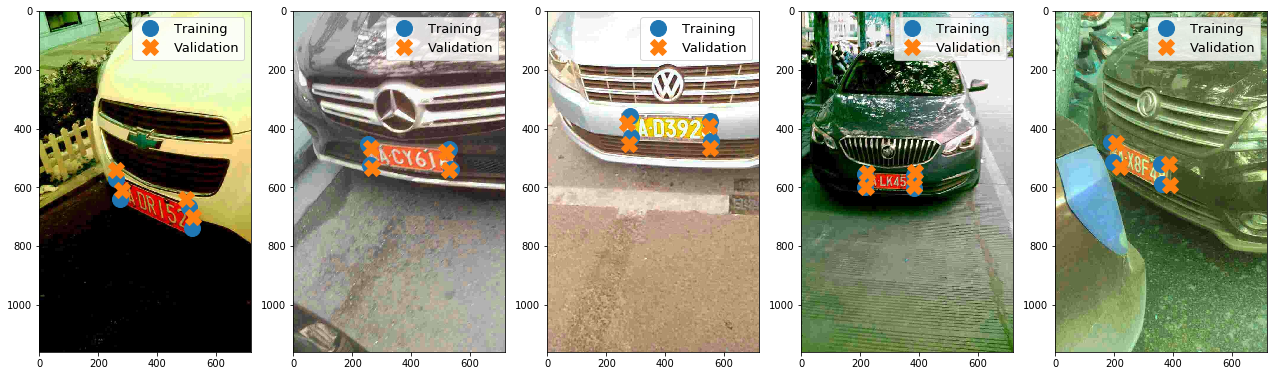

In [0]:
rand = np.random.rand(25)
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img5(np.int(rand[0]*3000)); plt.subplot(1,5,2); show_img5(np.int(rand[1]*3000)); 
plt.subplot(1,5,3); show_img5(np.int(rand[2]*3000)); plt.subplot(1,5,4); show_img5(np.int(rand[3]*3000)); plt.subplot(1,5,5); show_img5(np.int(rand[4]*3000))
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img5(np.int(rand[5]*3000)); plt.subplot(1,5,2); show_img5(np.int(rand[6]*3000)); 
plt.subplot(1,5,3); show_img5(np.int(rand[7]*3000)); plt.subplot(1,5,4); show_img5(np.int(rand[8]*3000)); plt.subplot(1,5,5); show_img5(np.int(rand[9]*3000))
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img5(np.int(rand[10]*3000)); plt.subplot(1,5,2); show_img5(np.int(rand[11]*3000)); 
plt.subplot(1,5,3); show_img5(np.int(rand[12]*3000)); plt.subplot(1,5,4); show_img5(np.int(rand[13]*3000)); plt.subplot(1,5,5); show_img5(np.int(rand[14]*3000))
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img5(np.int(rand[15]*3000)); plt.subplot(1,5,2); show_img5(np.int(rand[16]*3000)); 
plt.subplot(1,5,3); show_img5(np.int(rand[17]*3000)); plt.subplot(1,5,4); show_img5(np.int(rand[18]*3000)); plt.subplot(1,5,5); show_img5(np.int(rand[19]*3000))
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img5(np.int(rand[20]*3000)); plt.subplot(1,5,2); show_img5(np.int(rand[21]*3000)); 
plt.subplot(1,5,3); show_img5(np.int(rand[22]*3000)); plt.subplot(1,5,4); show_img5(np.int(rand[23]*3000)); plt.subplot(1,5,5); show_img5(np.int(rand[24]*3000))

(3) Overlay training losses and validation losses in the same figure against step or epoch

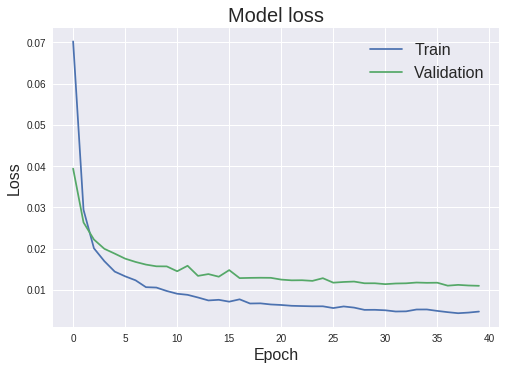

In [0]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize=16)
plt.show()

Training RMSE:

In [0]:
sqq=0
for index in range(1000):
    img_test = cv2.resize(cv2.imread("./ccpd6000/train_images/" + label["name"].iloc[index]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img_test.reshape(1, HEIGHT,WIDTH, 3))
    sq = 0
    for i in range(4):
         sq = sq + ((y_hat[0][i*2]*img.shape[1] - label.iloc[index,i*2+1])**2 + (y_hat[0][i*2+1]*img.shape[0] - label.iloc[index,i*2+2])**2)/8
    sqq = sqq + sq

print("RMSE of training set: ", np.power(sqq/1000,0.5))

RMSE of training set:  16.768414676224207


## 5. Testing & update predict result (test.csv)

In [0]:
test = pd.read_csv('./ccpd6000/sample.csv')
test.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
0,0000.jpg,360.0,580.0,360.0,580.0,360.0,580.0,360.0,580.0
1,0001.jpg,360.0,580.0,360.0,580.0,360.0,580.0,360.0,580.0
2,0002.jpg,360.0,580.0,360.0,580.0,360.0,580.0,360.0,580.0
3,0003.jpg,360.0,580.0,360.0,580.0,360.0,580.0,360.0,580.0
4,0004.jpg,360.0,580.0,360.0,580.0,360.0,580.0,360.0,580.0


In [0]:
for index in range(3000):
    img_test = cv2.resize(cv2.imread("./ccpd6000/test_images/" + test["name"].iloc[index]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img_test.reshape(1, HEIGHT,WIDTH, 3))
    # X
    test.iloc[index,1] = np.int(y_hat[0][0]*img.shape[1])
    test.iloc[index,3] = np.int(y_hat[0][2]*img.shape[1])
    test.iloc[index,5] = np.int(y_hat[0][4]*img.shape[1])
    test.iloc[index,7] = np.int(y_hat[0][6]*img.shape[1])
    # Y
    test.iloc[index,2] = np.int(y_hat[0][1]*img.shape[0])
    test.iloc[index,4] = np.int(y_hat[0][3]*img.shape[0])
    test.iloc[index,6] = np.int(y_hat[0][5]*img.shape[0])
    test.iloc[index,8] = np.int(y_hat[0][7]*img.shape[0])

test.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
0,0000.jpg,391.0,612.0,287.0,555.0,279.0,493.0,380.0,550.0
1,0001.jpg,442.0,537.0,284.0,535.0,278.0,492.0,438.0,492.0
2,0002.jpg,456.0,506.0,352.0,505.0,355.0,481.0,458.0,479.0
3,0003.jpg,504.0,596.0,308.0,574.0,305.0,521.0,495.0,538.0
4,0004.jpg,430.0,572.0,161.0,581.0,158.0,519.0,426.0,509.0


In [0]:
def show_img4(index):
    img = cv2.imread("./ccpd6000/test_images/" + test["name"].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_list = []; y_list = []
    for i in range(4):
        x_list.append(test.iloc[index,i*2+1])
        y_list.append(test.iloc[index,i*2+2])
    plt.plot(x_list,y_list,"o", label="red point",markersize=13)
    plt.legend(['Testing'], loc='upper right',fontsize=13)
    plt.imshow(img)

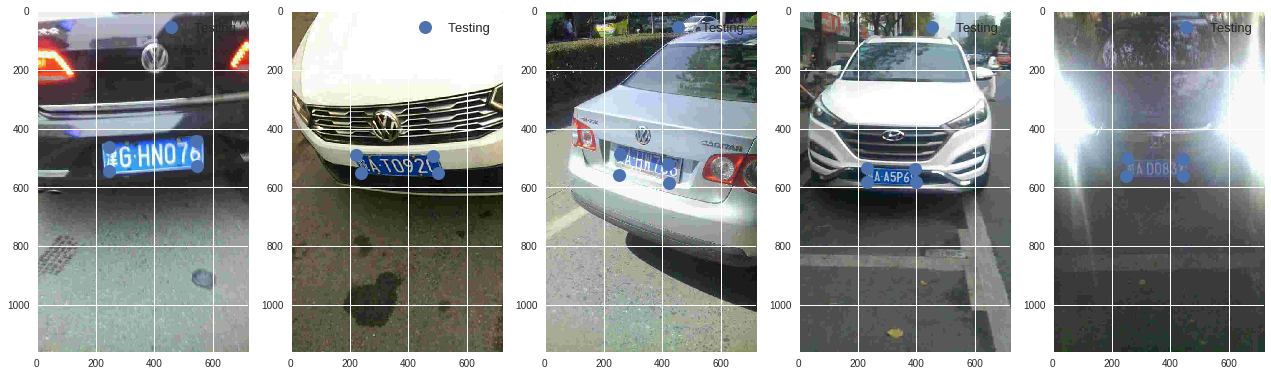

In [0]:
rand = np.random.rand(5)
plt.figure(figsize=(22,10)); plt.subplot(1,5,1); show_img4(np.int(rand[0]*3000)); plt.subplot(1,5,2); show_img4(np.int(rand[1]*3000)); 
plt.subplot(1,5,3); show_img4(np.int(rand[2]*3000)); plt.subplot(1,5,4); show_img4(np.int(rand[3]*3000)); plt.subplot(1,5,5); show_img4(np.int(rand[4]*3000))

In [0]:
test.to_csv(r'./ccpd6000/test.csv',index=False)

In [0]:
test2 = pd.read_csv('./ccpd6000/test.csv')
test2.head()

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
0,0000.jpg,391.0,612.0,287.0,555.0,279.0,493.0,380.0,550.0
1,0001.jpg,442.0,537.0,284.0,535.0,278.0,492.0,438.0,492.0
2,0002.jpg,456.0,506.0,352.0,505.0,355.0,481.0,458.0,479.0
3,0003.jpg,504.0,596.0,308.0,574.0,305.0,521.0,495.0,538.0
4,0004.jpg,430.0,572.0,161.0,581.0,158.0,519.0,426.0,509.0


(4) Testing and  RMSE = 20 ≤ 35

In [0]:
!curl -F "file=@./ccpd6000/test.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 16
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Sat, 07 Dec 2019 17:53:34 GMT

{"rmse":20.888}
